In [32]:
import numpy as np
import pymc as pm
import pytensor
pytensor.config.cxx = '/usr/bin/clang++'

In [33]:
mu_prior = np.zeros(40)
sigma_prior = np.ones(40) * 10
optimizer = pm.adagrad()
max_iters = 100_000

# Generate 3 observations for each dimension
np.random.seed(42)
n_obs = 3
observed_data = np.random.normal(loc=2.0, scale=1.0, size=(n_obs, 40))  # 3 observations per dimension

# Compute analytical posterior (conjugate prior-likelihood)
# Prior: mu ~ N(mu_prior, sigma_prior^2)
# Likelihood: y_i ~ N(mu, 1^2) for i=1,2,3
# Posterior: mu ~ N(mu_post, sigma_post^2)

sigma_likelihood = 1.0
precision_prior = 1 / (sigma_prior**2)  # 1/100 for each dimension
precision_likelihood = 1 / (sigma_likelihood**2)  # 1 for each observation

# Posterior precision = prior precision + n_obs * likelihood precision
precision_post = precision_prior + n_obs * precision_likelihood
sigma_post = 1 / np.sqrt(precision_post)

# Posterior mean = (precision_prior * mu_prior + precision_likelihood * sum(y_i)) / precision_post
y_mean = np.mean(observed_data, axis=0)  # Mean of 3 observations for each dimension
mu_post = (precision_prior * mu_prior + n_obs * precision_likelihood * y_mean) / precision_post

print(f"True posterior mean (first dim): {mu_post[0]:.4f}")
print(f"True posterior std (first dim): {sigma_post[0]:.4f}")
print(f"Observed data mean (first dim): {y_mean[0]:.4f}")

with pm.Model() as single_model:
    # Define priors
    mu = pm.Normal('mu', mu_prior, sigma_prior, shape=40)
    # Define likelihood with 3 observations
    y = pm.Normal('y', mu, sigma=np.ones(40), observed=observed_data)

    advi = pm.ADVI(random_seed=42)
    single_tracker = pm.callbacks.Tracker(
        mean=advi.approx.mean.eval,
        cov=advi.approx.cov.eval
    )
    single_approx = advi.fit(
        max_iters,
        callbacks=[single_tracker],
        obj_n_mc=1,
        obj_optimizer=optimizer
    ) 

with pm.Model() as multi_model:
    # Define priors
    mu = pm.Normal('mu', mu_prior, sigma_prior, shape=40)
    # Define likelihood with 3 observations
    y = pm.Normal('y', mu, sigma=np.ones(40), observed=observed_data)

    advi = pm.ADVI(random_seed=42)
    multi_tracker = pm.callbacks.Tracker(
        mean=advi.approx.mean.eval,
        cov=advi.approx.cov.eval
    )
    multi_approx = advi.fit(
        max_iters,
        callbacks=[multi_tracker],
        obj_n_mc=100,
        obj_optimizer=optimizer
    )

True posterior mean (first dim): 2.3307
True posterior std (first dim): 0.5764
Observed data mean (first dim): 2.3385


Output()

Finished [100%]: Average Loss = 260.43


Output()

Finished [100%]: Average Loss = 260.35


Single tracker data shape - means: (100000, 40), covs: (100000, 40, 40)
Multi tracker data shape - means: (100000, 40), covs: (100000, 40, 40)
Final ADVI mean (first dim): 2.2691
Final ADVI std (first dim): 0.5770
True posterior mean (first dim): 2.3307
True posterior std (first dim): 0.5764
Final ADVI mean (first dim): 2.2691
Final ADVI std (first dim): 0.5770
True posterior mean (first dim): 2.3307
True posterior std (first dim): 0.5764


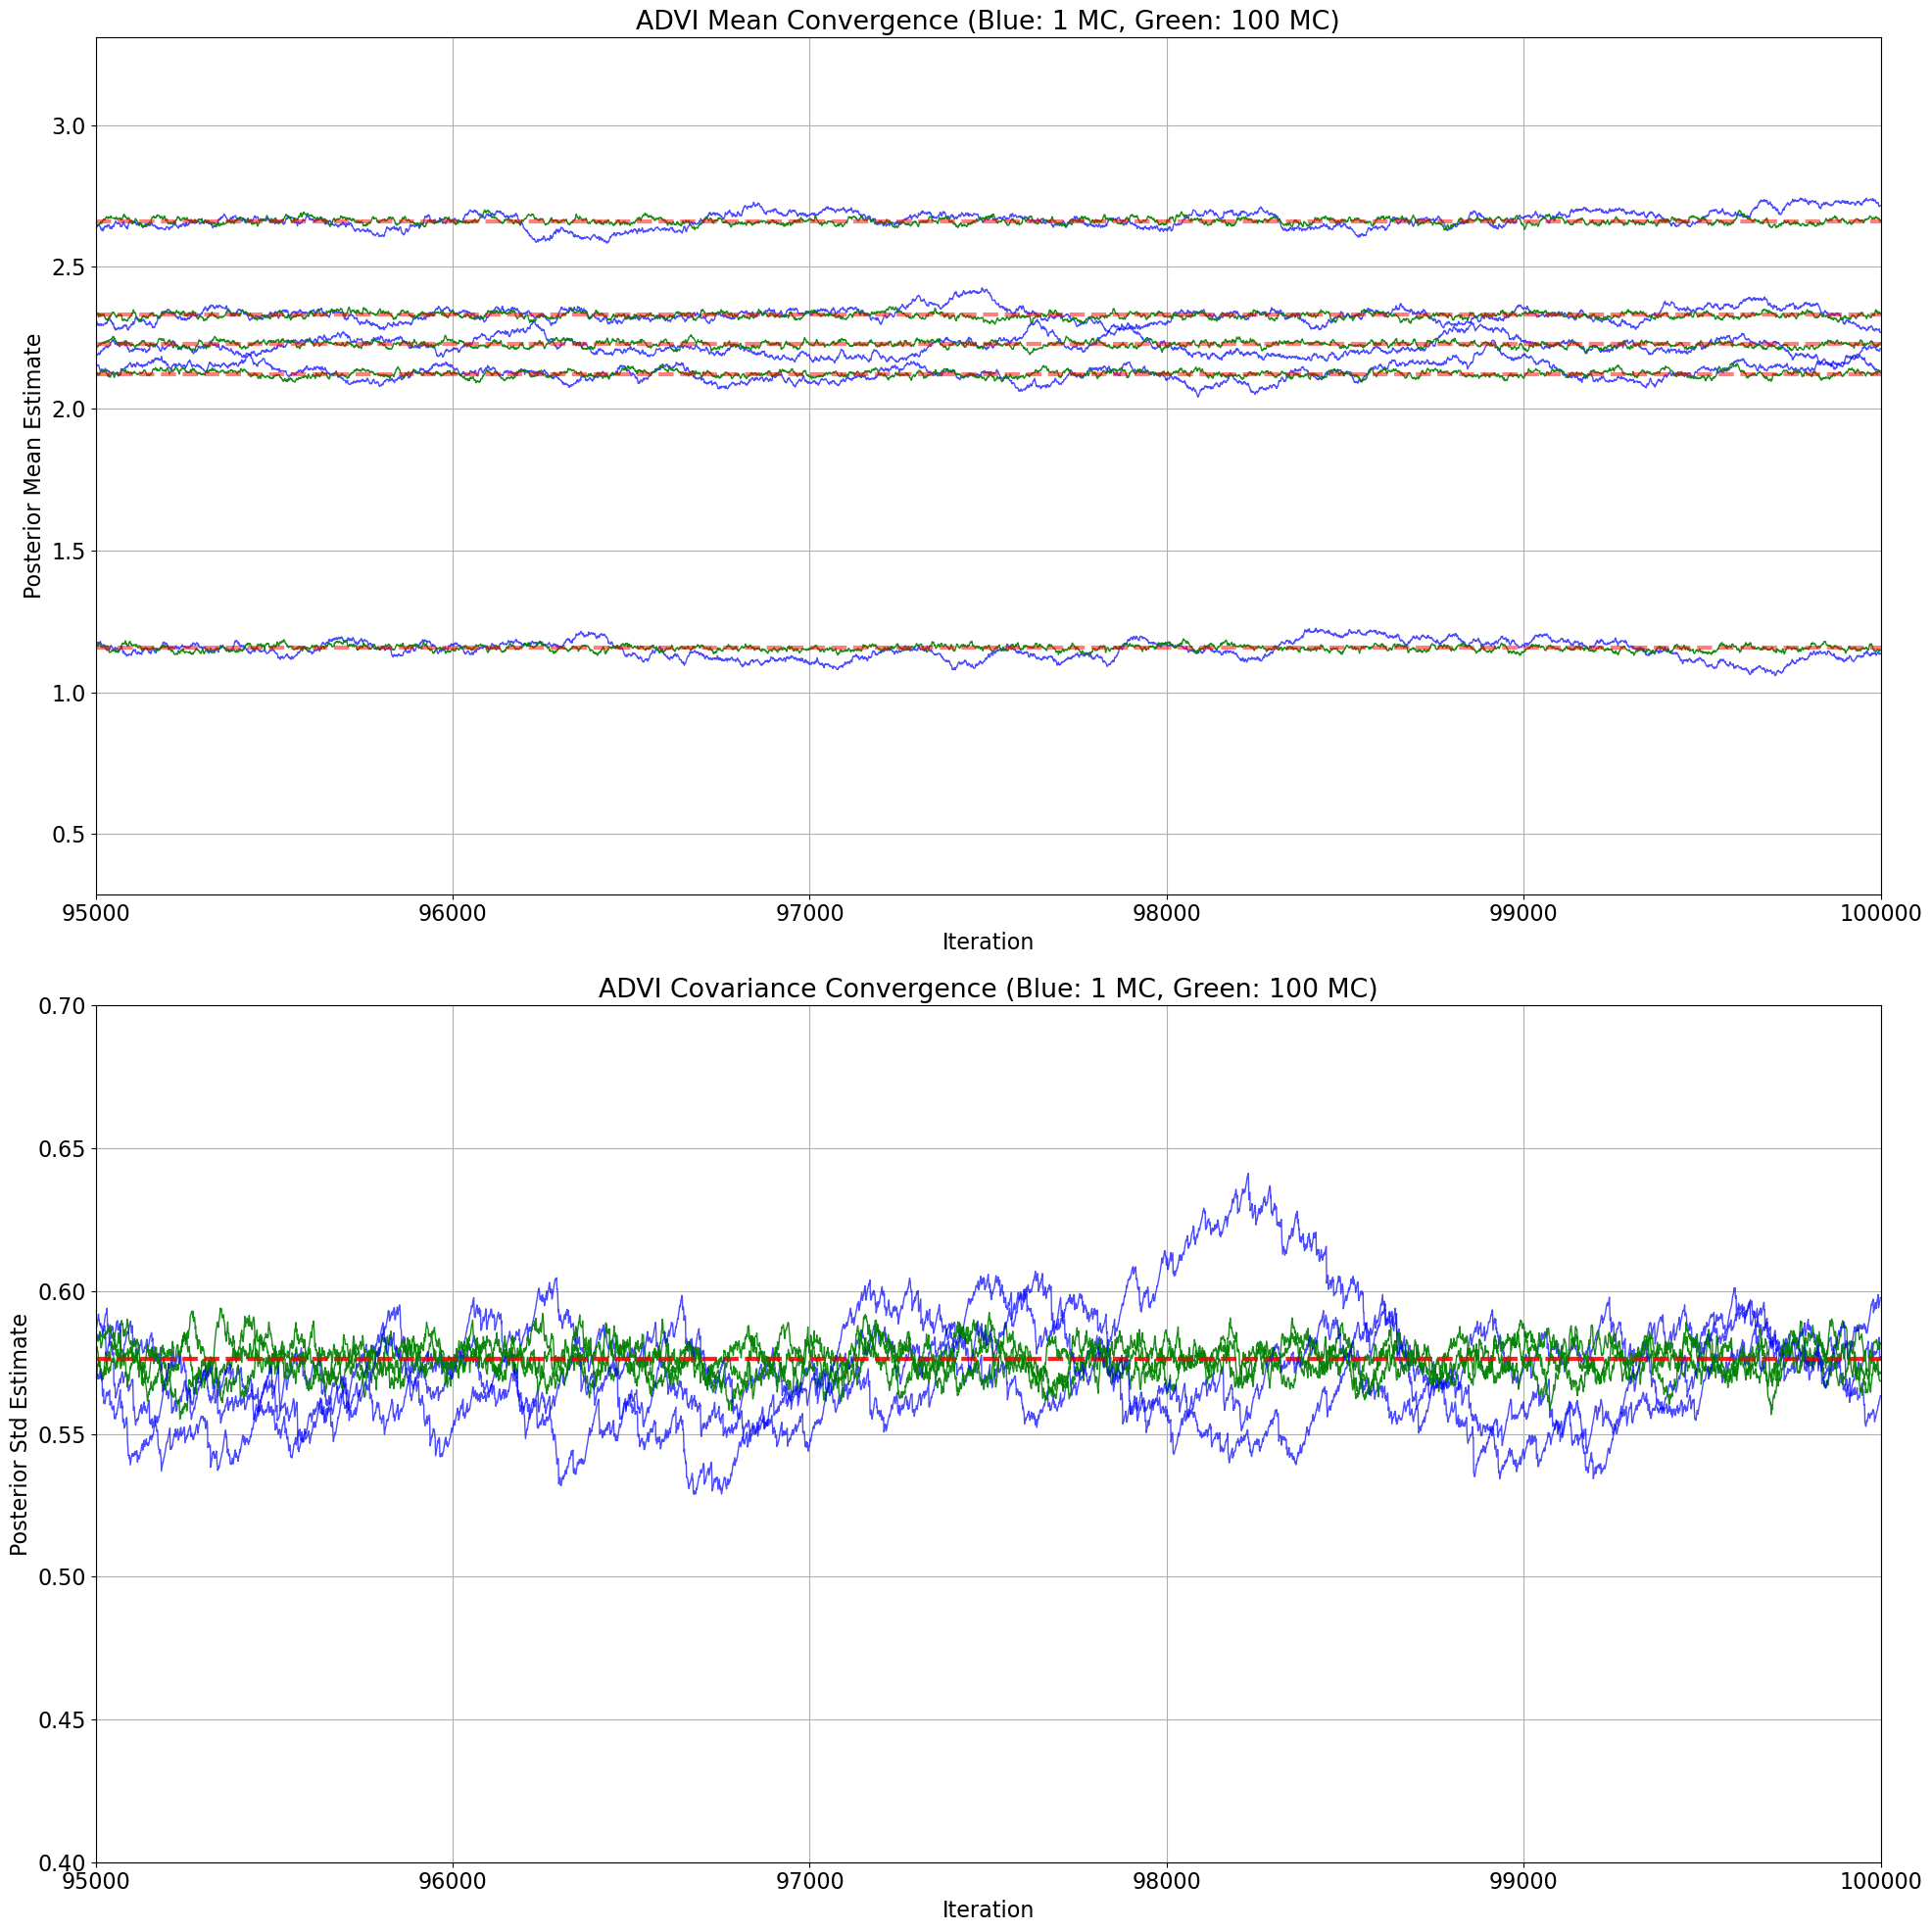


Final Convergence Errors (First Dimension):
Single MC - Mean Error: 0.0617, Std Error: 0.0006
Multi MC  - Mean Error: 0.0040, Std Error: 0.0051


In [42]:
import matplotlib.pyplot as plt

# Extract tracker data
means = np.array(single_tracker['mean'])
covs = np.array(single_tracker['cov'])
multi_means = np.array(multi_tracker['mean'])
multi_covs = np.array(multi_tracker['cov'])

print(f"Single tracker data shape - means: {means.shape}, covs: {covs.shape}")
print(f"Multi tracker data shape - means: {multi_means.shape}, covs: {multi_covs.shape}")

# Extract the actual standard deviations from the covariance matrices
# For the first 40 dimensions (mu parameters), extract the diagonal (variances) and take sqrt
mu_covs = covs[:, :40, :40]  # Extract the 40x40 covariance block for mu parameters
actual_scales = np.sqrt(np.diagonal(mu_covs, axis1=1, axis2=2))  # Diagonal = variances, sqrt = std devs

multi_mu_covs = multi_covs[:, :40, :40]
multi_actual_scales = np.sqrt(np.diagonal(multi_mu_covs, axis1=1, axis2=2))

print(f"Final ADVI mean (first dim): {means[-1, 0]:.4f}")
print(f"Final ADVI std (first dim): {actual_scales[-1, 0]:.4f}")
print(f"True posterior mean (first dim): {mu_post[0]:.4f}")
print(f"True posterior std (first dim): {sigma_post[0]:.4f}")

# Create plots using the provided style
colors = plt.cm.viridis(np.linspace(0, 1, 10))
fig, ax = plt.subplots(2, 1, figsize=(20, 20))
plt.rcParams.update({'font.size': 16})

# Plot means for first few dimensions
for dim in range(min(5, 40)):  # Plot first 5 dimensions for clarity
    ax[0].plot(means[:, dim], color='blue', alpha=0.7, linewidth=1)
    ax[0].plot(multi_means[:, dim], color='green', alpha=0.9, linewidth=1)

# Add true posterior values
    ax[0].axhline(mu_post[dim], color='red', alpha=0.5, linestyle='--', linewidth=3, 
              label=f'True Posterior Mean ≈ {mu_post[dim]:.3f}')
ax[0].set_title('ADVI Mean Convergence (Blue: 1 MC, Green: 100 MC)')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Posterior Mean Estimate')
# ax[0].legend()
ax[0].grid()

# Plot standard deviations for first few dimensions
for dim in range(min(3, 40)):  # Plot first 5 dimensions for clarity
    ax[1].plot(actual_scales[:, dim], color='blue', alpha=0.7, linewidth=1)
    ax[1].plot(multi_actual_scales[:, dim], color='green', alpha=0.9, linewidth=1)

    ax[1].axhline(sigma_post[dim], color='red', linestyle='--', linewidth=3, alpha=0.5,
              label=f'True Posterior Std ≈ {sigma_post[dim]:.2f}')
ax[1].set_title('ADVI Covariance Convergence (Blue: 1 MC, Green: 100 MC)')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Posterior Std Estimate')
# ax[1].legend()
ax[1].grid()
ax[0].set_xlim(95_000, 100_000)
ax[1].set_xlim(95_000, 100_000)
ax[1].set_ylim(0.4, 0.7)

plt.tight_layout()
plt.show()

# Show convergence error
final_mean_error_single = np.abs(means[-1, 0] - mu_post[0])
final_std_error_single = np.abs(actual_scales[-1, 0] - sigma_post[0])
final_mean_error_multi = np.abs(multi_means[-1, 0] - mu_post[0])
final_std_error_multi = np.abs(multi_actual_scales[-1, 0] - sigma_post[0])

print(f"\nFinal Convergence Errors (First Dimension):")
print(f"Single MC - Mean Error: {final_mean_error_single:.4f}, Std Error: {final_std_error_single:.4f}")
print(f"Multi MC  - Mean Error: {final_mean_error_multi:.4f}, Std Error: {final_std_error_multi:.4f}")